In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

import cufflinks as cf
cf.go_offline()

import pandas as pd
import numpy as np
import scipy
import jhtalib as jhta

In [3]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = '_Bi_'  # ES only
#exo_filter = 'ES*Collar'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

# [print(exo) for exo in storage.exo_list(exo_filter)];

In [4]:
def rolling_zscore_transform(x, period=25):
    return (x - x.rolling(period).mean()) / x.rolling(period).std()

In [5]:
from sklearn import (pipeline, preprocessing, ensemble, neighbors, model_selection)
from scipy import signal, ndimage

from sklearn import (pipeline, preprocessing, ensemble, cluster, svm
                    )

import ta

def clean_dataset(data):
    """
    Input data must be series or DF
    """
    #data.dropna(inplace=True)
    return data.replace([np.inf, -np.inf], np.nan).ffill().dropna()

class Strategy_ML_Test(StrategyBase):
    name = 'Strategy_ML_Test'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calc_entryexit_rules(self, lookback, n_clusters, random_state, direction):
        
        n = lookback # look back days for indicators

        #o = ?
        #h = ?
        #l = ?
        #c = exo
        
        c = self.data.exo
        
        o = c.shift(1).bfill()
        h = c.rolling(2).max().bfill()
        l = c.rolling(2).min().bfill()
        
        df = pd.DataFrame()
        df['Close'] = c
        df['High'] = h
        df['Low'] = l
        df['Open'] = o
        
        features = pd.DataFrame(index=c.index)

#         features['RSI'] = ta.rsi(c, n).rolling(50).mean()#ES Long feature
#         features['donchian_channel_lband'] = ta.donchian_channel_lband(c, n=90, fillna=False)#ES Long feature
#         features['keltner_channel_lband'] = ta.keltner_channel_hband(h, l, c, n=10, fillna=False).rolling(10).median()  #ES Long feature 

#         features['cci'] = ta.cci(h, l, c, n=n, c=0.035, fillna=False).rolling(90).max()  #ES Long feature 
    
#         features['kst'] = ta.kst(c, r1=100, r2=15, r3=20, r4=130, n1=10, n2=100, n3=10, n4=150, fillna=False).rolling(10).max()
    
#         features['adx_neg'] = ta.adx_neg(c, c, c, n=14, fillna=False) #ZB Long feature
#         features['adx_pos'] = ta.adx_pos(c, c, c, n=14, fillna=False) #
#         features['aroon_up_1'] = ta.aroon_up(c, 95)
#         features['aroon_down_1'] = ta.aroon_down(c, 5)
                                            #ES Long feature #features['aroon_up_1'] = ta.aroon_up(c, n), features['aroon_down_1'] = ta.aroon_down(c, 20)
#         features['bollinger_hband_1'] = ta.bollinger_lband(c, n=n, ndev=0.2, fillna=False)      
#         features['bollinger_hband_2'] = ta.bollinger_lband(c, n=n, ndev=0.4, fillna=False)# #ES Long feature
#         features['bollinger_hband_3'] = ta.bollinger_hband(c, n=n, ndev=2.1, fillna=False)# #ES Long feature
#         features['bollinger_hband_2'] = ta.bollinger_hband_indicator(c, n=n, ndev=0.75, fillna=False)     
        features['bollinger_lband_2'] = ta.bollinger_lband_indicator(c, n=n, ndev=0.75, fillna=False)


#         features['aroon_up_2'] = ta.aroon_up(c, n)
#         features['aroon_up_3'] = ta.aroon_up(c, 20)
#         features['aroon_up_4'] = ta.aroon_up(c, 30)
#         features['Corr'] =  c.rolling(window=n).mean().rolling(window=n).corr(c)
#         features['ATR'] = ta.average_true_range(h, l, c, n).rolling(n+15).mean() #ES Long feature Looks like PAM
        features['ATR_1'] = ta.average_true_range(h, l, c, n).rolling(5).mean() #ES Long feature, ES Short feature
        features['SAR_1'] = pd.DataFrame(jhta.SAR(df, af_step=0.1, af_max=0.015),index=c.index)
        features['SAR_2'] = pd.DataFrame(jhta.SAR(df, af_step=0.41, af_max=0.185),index=c.index)
    
        features = rolling_zscore_transform(features, 25)


        #target = np.log(df['Open'] / df['Open'].shift(-1)) > 0 
        target = np.log(o / o.shift(1)) > 0 
        #target = np.log(c / c.shift(1)) > 0 
        #target = np.log(c / c.shift(-1)) > 0 
        
        #target = c.pct_change(-1) > 0

        features = clean_dataset(features)
        target = clean_dataset(target)

        target = target.reindex(features.index)
        
        train_features, test_features, train_target, test_target = model_selection.train_test_split(features, target, 
                                                                                                    test_size=0.2, shuffle=False) #
        
        regimes_mdl = pipeline.make_pipeline(preprocessing.StandardScaler(), cluster.KMeans(n_clusters, random_state=random_state))
        regimes_mdl.fit(train_features)
        
        ## Regimes as feature

        features['regime'] = regimes_mdl.predict(features).astype(float)
        train_features['regime'] = regimes_mdl.predict(train_features).astype(float)
        test_features['regime'] = regimes_mdl.predict(test_features).astype(float)
        
        cls = pipeline.make_pipeline(preprocessing.StandardScaler(),
                             svm.SVC(C=10, cache_size=100, class_weight='balanced', coef0=3.0,
                                     decision_function_shape=None, degree=4, 
                                     gamma='auto', kernel='rbf', max_iter=-1, probability=False, 
                                     random_state=random_state, shrinking=True, tol=0.001, verbose=False))

        cls.fit(train_features, train_target)
        
        pred = pd.Series(cls.predict(features), index=features.index, name='prediction')
        
        pred_aligned = pred.reindex_like(c).fillna(False)

        if direction == 1:
            entry_rule = pred_aligned == True
            exit_rule = pred_aligned == False
            
        if direction == -1:
            entry_rule = pred_aligned == False
            exit_rule = pred_aligned == True
            
        return entry_rule, exit_rule
        
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            (direction, lookback, n_clusters, random_state) = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            (direction, lookback, n_clusters, random_state) = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule, exit_rule = self.calc_entryexit_rules(lookback, n_clusters, random_state, direction)

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

In [6]:
# lookback, n_clusters
STRATEGY_CONTEXT = {
        'strategy': { 
            'class': Strategy_ML_Test,
            'exo_name': 'ES_ContFut',        # <---- Select and paste EXO name from cell above
            'exo_storage': storage,
            'opt_params': [
                    OptParamArray('Direction', [1]),
                    OptParamArray('Lookback days', [3,11,50]),
                    OptParamArray('n Clusters', [2,7, 11, 45]),
                    OptParam('Random state', 0, 0, 20, 20),
#                     OptParamArray('Trigger Cluster', np.arange(0, 10, 1)),
                ],
        },    
        'swarm': {
            'members_count': 1,
            'ranking_class': RankerHighestReturns(120),
            'rebalance_time_function': SwarmRebalance.every_friday,

        },
        'costs':{
            'manager': CostsManagerEXOFixed,
            'context': {
                'costs_options': 3.0,
                'costs_futures': 3.0,
            }
        }
    }

# Backtest class based strategy

In [7]:
import warnings; warnings.simplefilter('ignore')

In [8]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()



In [9]:
#from backtester.reports.alpha_sanity_checks import AlphaSanityChecker
#asc = AlphaSanityChecker(smgr)
#asc.run()

In [10]:
direction = STRATEGY_CONTEXT['strategy']['opt_params'][0].array[0]

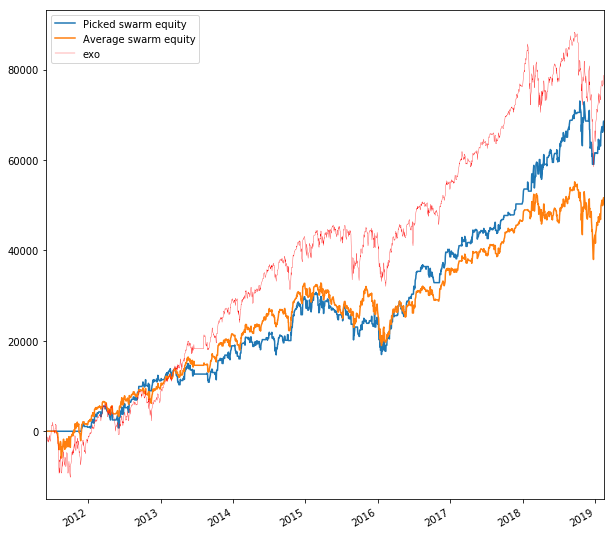

In [133]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
(smgr.strategy.data.exo*direction).plot(linewidth=0.3, color='red')
#axvline(last_opt_date)
legend(loc=2);

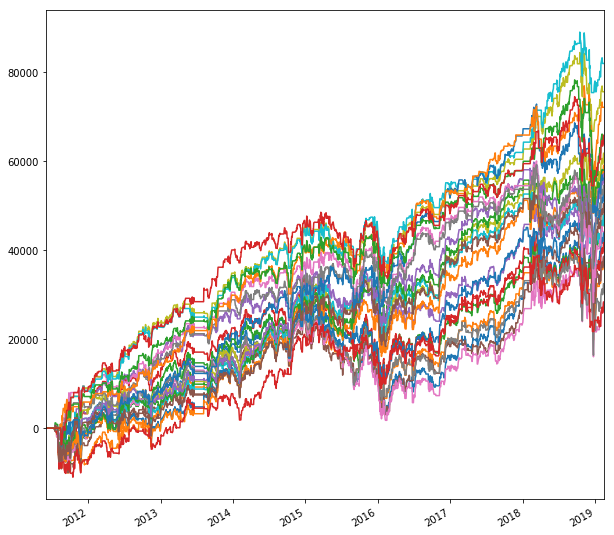

In [134]:

smgr.raw_swarm.plot(legend=False, )